In [1]:
import os
import sys
import glob
import random
import warnings
import itertools
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import cv2  # pip install opencv-python
#from PIL import Image
#from PIL import ImageFont
#from PIL import ImageDraw
#from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, ElementTree
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score




#from pathlib import Path
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization ,Conv2D,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam,SGD
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.losses import categorical_crossentropy,binary_crossentropy
from tensorflow.keras.callbacks import Callback,LearningRateScheduler
from tensorflow.python.client import device_lib



In [2]:
os.getcwd()

'D:\\Projects\\JupyterMLserver\\Projects\\test\\hw\\capstone'

In [3]:
#import os
# import random
# from shutil import copyfile

# source_dir = './data/'  # Source directory with your data
# train_dir = './data/train/'  # Destination directory for training data
# test_dir = './data/test/'    # Destination directory for testing data

# # Create the train and test directories if they don't exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Define the ratio of data to be used for training
# train_ratio = 0.8  # 80% for training, 20% for testing
# CLASS_NAMES = ['key','wallet']
# # Iterate through your class names (e.g., "true" and "false")
# for class_name in CLASS_NAMES:
#     class_source_dir = os.path.join(source_dir, class_name)
#     class_train_dir = os.path.join(train_dir, class_name)
#     class_test_dir = os.path.join(test_dir, class_name)

#     # Create the class-specific train and test directories
#     os.makedirs(class_train_dir, exist_ok=True)
#     os.makedirs(class_test_dir, exist_ok=True)

#     # List all files in the source directory for the current class
#     file_list = os.listdir(class_source_dir)

#     # Shuffle the file list to randomly split the data
#     random.shuffle(file_list)

#     # Calculate the number of files for training and testing based on the ratio
#     num_files = len(file_list)
#     num_train_files = int(train_ratio * num_files)

#     # Move the files to the appropriate train and test directories
#     for i, file_name in enumerate(file_list):
#         source_file = os.path.join(class_source_dir, file_name)
#         if i < num_train_files:
#             destination_dir = class_train_dir
#         else:
#             destination_dir = class_test_dir
#         destination_file = os.path.join(destination_dir, file_name)

#         copyfile(source_file, destination_file)

# # Now your data is split into train and test directories


In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

base_dir = Path('./data')

train_dir = './data/train/'
test_dir = './data/test/'


BATCH_SIZE = 1
IMG_HEIGHT = 64
IMG_WIDTH = 64
image_count = len(list(base_dir.glob('*.jpg')))
print(image_count)
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = ["key","wallet"]

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 데이터의 20%를 검증 데이터로 분할
)

train_data_gen = train_data_generator.flow_from_directory(
    directory=str(train_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=list(CLASS_NAMES),
    class_mode="categorical",
    
    
    # ======================================================================================
    #color_mode="grayscale", # 추가한 부분
    # ======================================================================================
    
    
    
    subset='training'  # 학습 데이터 생성기로 설정
    
    #class_mode="binary",
    #categorical 2D one-hot 부호화된 라벨 반환
    #binary : 1D Binary 라벨 반환
    #spares : 1D 정수 라벨 반환
    #none : 라벨 반환이 안됨.
)

validation_data_gen = train_data_generator.flow_from_directory(
    directory=str(train_dir),
    batch_size=BATCH_SIZE,
    shuffle=False,  # 검증 데이터는 섞지 않음
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=list(CLASS_NAMES),
    class_mode="categorical",
    
    
    
     # ======================================================================================
    #color_mode="grayscale", # 추가한 부분
     # ======================================================================================
    
    
    
    
    subset='validation'  # 검증 데이터 생성기로 설정
)

test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),                                          
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES),
    class_mode="categorical",
                                                    
                                                 
                                                    
                                                    
                                                    
     # ======================================================================================                                                
    #color_mode="grayscale", # 추가한 부분
     # ======================================================================================  
                                                    
                                                    
                                                    
)


# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10,10))
#     for n in range(25):
#         ax = plt.subplot(5,5,n+1)
#         plt.imshow(image_batch[n])
#         if label_batch[n][0] == 1:
#             label = "true"
#         else:
#             label = "false"
        
#         plt.title(label)
#         plt.axis('off')
        
        
# image_batch, label_batch = next(train_data_gen)
# show_batch(image_batch, label_batch)


0
Found 303 images belonging to 2 classes.
Found 74 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [5]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())


model.add(Dense(2, activation='softmax'))

# 모델 아키텍처 확인
model.summary()



# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                        

In [6]:

# 모델 훈련
history = model.fit(
    train_data_gen,
    epochs=10,  # 필요에 따라 조정
    validation_data=validation_data_gen
)


Epoch 1/10
303/303 [==============================] - 7s 9ms/step - loss: 1.7299 - accuracy: 0.7657 - val_loss: 1.4081 - val_accuracy: 0.6892
Epoch 2/10
303/303 [==============================] - 2s 8ms/step - loss: 0.9296 - accuracy: 0.8548 - val_loss: 2.9252 - val_accuracy: 0.6351
Epoch 3/10
303/303 [==============================] - 2s 8ms/step - loss: 0.5872 - accuracy: 0.8977 - val_loss: 2.9885 - val_accuracy: 0.8108
Epoch 4/10
303/303 [==============================] - 2s 8ms/step - loss: 0.3115 - accuracy: 0.9406 - val_loss: 2.0859 - val_accuracy: 0.8378
Epoch 5/10
303/303 [==============================] - 2s 8ms/step - loss: 0.1606 - accuracy: 0.9703 - val_loss: 2.0071 - val_accuracy: 0.8514
Epoch 6/10
303/303 [==============================] - 2s 8ms/step - loss: 0.2194 - accuracy: 0.9604 - val_loss: 2.4039 - val_accuracy: 0.8243
Epoch 7/10
303/303 [==============================] - 2s 8ms/step - loss: 0.1335 - accuracy: 0.9868 - val_loss: 2.2844 - val_accuracy: 0.8514
Epoch 

In [7]:
test_loss, test_accuracy = model.evaluate(test_data_gen, verbose=2)

print(f"Test accuracy: {test_accuracy:.4f}")

98/98 - 0s - loss: 2.9703 - accuracy: 0.7653 - 330ms/epoch - 3ms/step
Test accuracy: 0.7653


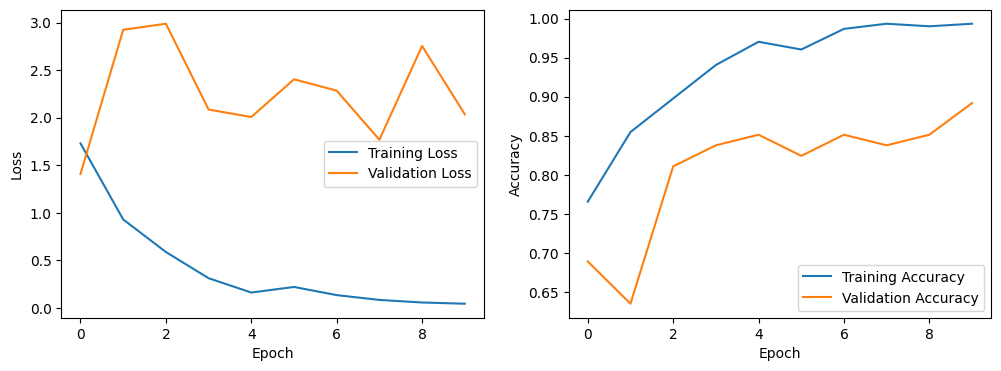

1/1 [==============================] - 0s 14ms/step


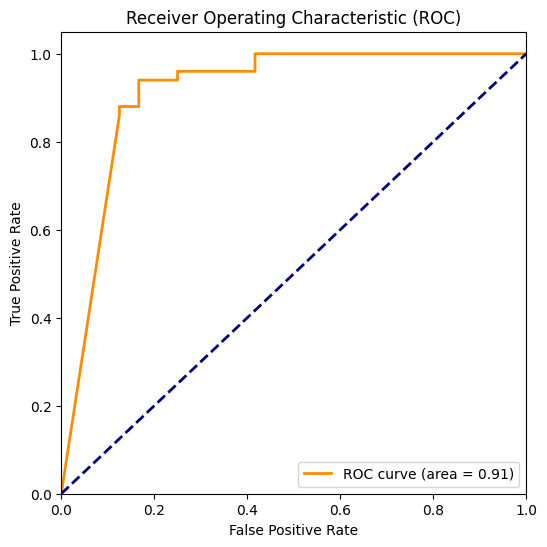

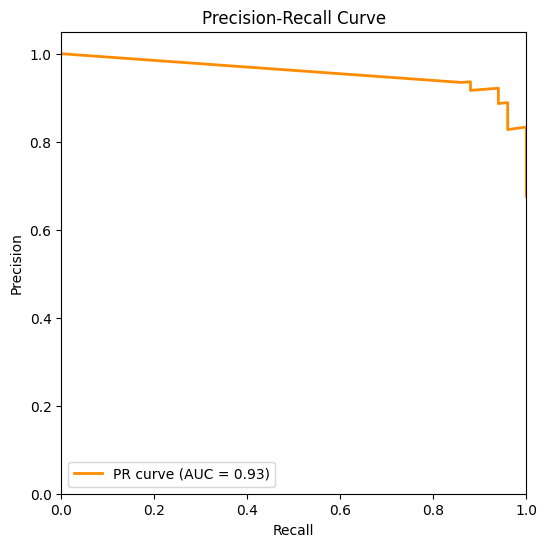

In [8]:
# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Calculate ROC curve and AUC
validation_data_gen.reset()
y_true = []
y_pred = []

for i in range(len(validation_data_gen)):
    x_val, y_val = validation_data_gen[i]
    y_true.extend(y_val)
    y_pred.extend(model.predict(x_val))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_true[:, 1], y_pred[:, 1])
pr_auc = average_precision_score(y_true[:, 1], y_pred[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()



In [9]:
model.save("capstone.h5")

In [3]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import os
print(tf.__version__)
print(device_lib.list_local_devices())

### GPU 사용
#os.environ["CUDA_VISIBLE_DEVICES"]= "0"


### CPU 사용
#os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

2.8.4
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6169824771277376234
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4850712576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11401288646967105459
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
